In [1]:
import torch
import numpy as np
from globalbiopak.linop import *
import matplotlib.pyplot as plt
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

# Data loading

cuda:2
torch.Size([292, 292, 292])


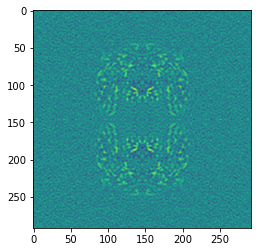

In [2]:
import gemmi
ccp4_map = gemmi.read_ccp4_map('../data/betagal2984.map')
data = torch.Tensor(np.array(ccp4_map.grid)).to(device)
print(data.device)
print(data.shape)
plt.imshow(data.cpu()[146, :, :])

# Low-pass filtering and downsampling

To avoid having to sample too many angles

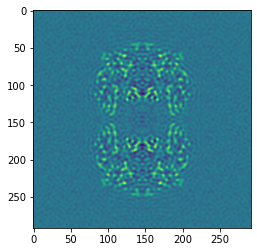

In [16]:
data = torch.Tensor(np.array(ccp4_map.grid)).to(device)
size = data.shape[0]
radius = int(size / 5)
center = int(size / 2)
x = np.linspace(0, size, size, dtype=np.uint)
xx,yy,zz = np.meshgrid(x, x, x)
mask = ((xx-center)**2 + (yy-center)**2 + (zz-center)**2) > radius**2

fdata = torch.fft.fftshift(torch.fft.fftn(data))
fdata[mask] = 0
data = torch.real(torch.fft.ifftn(torch.fft.ifftshift(fdata)))
plt.imshow(torch.log(torch.abs(fdata)).cpu()[146, :, :])
plt.imshow(data.cpu()[146, :, :])

downsampling_ratio = 1
data = data[::downsampling_ratio, ::downsampling_ratio, ::downsampling_ratio]

# Projections

In [17]:
import tomosipo as ts

# First define projection geometry
detector_shape = 300
pixel_size = np.sqrt(3) / detector_shape  # sqrt(3) is the diagonal of the unit cube
detector_position = (0, -2, 0)

pg = ts.parallel_vec(
    shape=detector_shape,
    ray_dir=(0, 1, 0),
    det_pos=detector_position,
    det_v=(pixel_size, 0, 0),
    det_u=(0, 0, pixel_size),
)

# Then define volume geometry
volume_size = np.array([1, 1, 1])
num_proj = 100
anglesrot = np.random.uniform(0, 0.5*np.pi, (num_proj, 1))
anglesazi = np.random.uniform(0, 0.2*np.pi, (num_proj, 1))
anglessph = np.random.uniform(0, 0.2*np.pi, (num_proj, 1))
axis = np.concatenate(
    (np.cos(anglessph), 
    np.sin(anglessph) * np.sin(anglesazi), 
    np.sin(anglessph) * np.cos(anglesazi)), 
    axis=1
)
rot_axis_pos = (0, 0, 0)

vg0 = ts.volume(
    shape=data.shape,
    pos=(0, 0, 0),
    size=volume_size,
)
R = ts.rotate(pos=rot_axis_pos, axis=axis, angles=anglesrot)
vg = R * vg0.to_vec()

A = ts.operator(vg, pg)
#ts.svg(vg, pg)

torch.Size([300, 100, 300])


/home/jdong/.conda/envs/tomosipo2/lib/python3.8/site-packages/tomosipo/links/torch.py:63: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  warnings.warn(


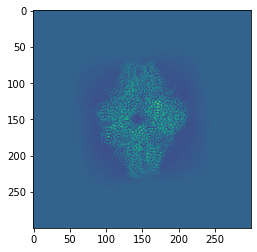

In [18]:
proj = A(data)
print(proj.shape)
plt.imshow(proj.cpu()[:, 0, :])

# Direct or Fourier space measurements

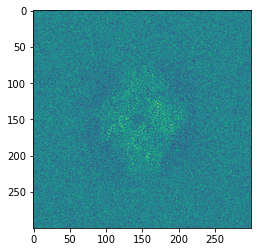

In [19]:
SNR = -5  # in dB
signal_lvl = torch.std(proj)
noise_lvl = signal_lvl * 10**(-SNR/10)
noise = torch.randn(proj.shape, device=device) * noise_lvl
direct_meas = proj + noise
plt.imshow(direct_meas.cpu()[:, 0, :])

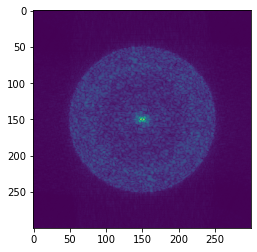

In [20]:
SNR = 100  # in dB
fourier_meas0 = torch.abs(torch.fft.ifftshift(torch.fft.fft2(proj, dim=(0, 2))))**2

signal_lvl = torch.std(fourier_meas0)
noise_lvl = signal_lvl * 10**(-SNR/10)
noise = torch.randn(proj.shape, device=device) * noise_lvl
fourier_meas = fourier_meas0 + noise
plt.imshow(torch.abs(fourier_meas[:, 0, :].cpu())**0.25)

# Template matching in real space

We do a simple grid search to test the noise robustness. More complex methods may be introduced later but they should just be faster and not more robust to noise.

In [8]:
volume_size = np.array([1, 1, 1])
Nsampl = 10
anglesrotlist = np.linspace(0, 0.5*np.pi, Nsampl)
anglesazilist = np.linspace(0, 0.2*np.pi, Nsampl)
anglessphlist = np.linspace(0, 0.2*np.pi, Nsampl)
templanglesrot, templanglesazi, templanglessph = np.meshgrid(anglesrotlist, anglesazilist, anglessphlist)
templanglesrot = np.reshape(templanglesrot, (Nsampl**3, 1))
templanglesazi = np.reshape(templanglesazi, (Nsampl**3, 1))
templanglessph = np.reshape(templanglessph, (Nsampl**3, 1))
templaxis = np.concatenate(
    (np.cos(templanglessph), 
    np.sin(templanglessph) * np.sin(templanglesazi), 
    np.sin(templanglessph) * np.cos(templanglesazi)), 
    axis=1
)
rot_axis_pos = (0, 0, 0)

vg0 = ts.volume(
    shape=data.shape,
    pos=(0, 0, 0),
    size=volume_size,
)
R = ts.rotate(pos=rot_axis_pos, axis=templaxis, angles=templanglesrot)
vg = R * vg0.to_vec()

A = ts.operator(vg, pg)
#ts.svg(vg, pg)

print(np.max(templanglesrot))
print(templanglesrot.shape)
print(templaxis.shape)

1.5707963267948966
(1000, 1)
(1000, 3)


In [9]:
template_proj = A(data)
print(template_proj.shape)

torch.Size([300, 1000, 300])


In [10]:
idx = 20
current_proj = proj[:, idx, :]

In [11]:
print(current_proj.shape)
print(template_proj.shape)

current_proj2 = current_proj - torch.mean(current_proj)
template_proj2 = template_proj - torch.mean(template_proj)
current_proj2 = torch.reshape(current_proj2, (detector_shape, 1, detector_shape))
correlations = torch.sum(template_proj2 * current_proj2, dim=(0, 2))
print(correlations.shape)
maxidx = torch.argmax(correlations)

torch.Size([300, 300])
torch.Size([300, 1000, 300])
torch.Size([1000])


In [12]:
target_rot = anglesrot[idx]
target_sph = anglessph[idx]
target_azi = anglesazi[idx]
target_axis = axis[idx, :]

print(templanglesrot[maxidx])
print(target_rot)
print(templanglessph[maxidx])
print(target_sph)
print(templanglesazi[maxidx])
print(target_azi)
print(templaxis[maxidx, :])
print(target_axis)

[0.17453293]
[0.26712257]
[0.06981317]
[0.11205907]
[0.]
[0.06474889]
[0.99756405 0.         0.06975647]
[0.99372795 0.00723547 0.11159036]


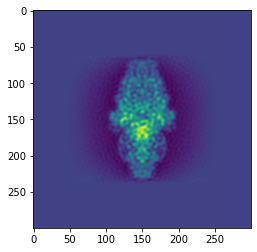

In [13]:
plt.imshow(proj[:, idx, :].cpu())

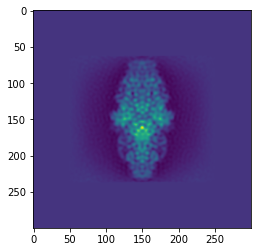

In [14]:
plt.imshow(template_proj[:, maxidx, :].cpu())

tensor(11, device='cuda:3')


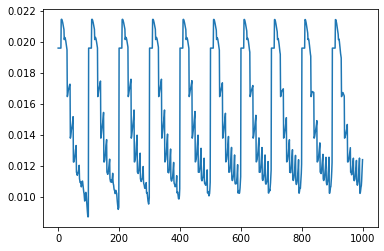

In [15]:
print(maxidx)
plt.plot(correlations.cpu())

# Testing the noise robustness of template matching

For different values of SNR of projections, we want to see how template matching performs. We will start by tidying codes with functions. 

In [16]:
 def generate_direct_proj(volume_data, num_proj=100, SNR=0, angle_scale=1):
    # First define projection geometry
    detector_shape = 300
    pixel_size = np.sqrt(3) / detector_shape  # sqrt(3) is the diagonal of the unit cube
    detector_position = (0, -2, 0)

    pg = ts.parallel_vec(
        shape=detector_shape,
        ray_dir=(0, 1, 0),
        det_pos=detector_position,
        det_v=(pixel_size, 0, 0),
        det_u=(0, 0, pixel_size),
    )

    # Then define volume geometry
    volume_size = np.array([1, 1, 1])
    anglesrot = np.random.uniform(0, 2*angle_scale*np.pi, (num_proj, 1))
    anglesazi = np.random.uniform(0, 2*angle_scale*np.pi, (num_proj, 1))
    anglessph = np.random.uniform(0, angle_scale*np.pi, (num_proj, 1))
    axis = np.concatenate(
        (np.cos(anglessph), 
        np.sin(anglessph) * np.sin(anglesazi), 
        np.sin(anglessph) * np.cos(anglesazi)), 
        axis=1
    )
    rot_axis_pos = (0, 0, 0)

    vg0 = ts.volume(
        shape=data.shape,
        pos=(0, 0, 0),
        size=volume_size,
    )
    R = ts.rotate(pos=rot_axis_pos, axis=axis, angles=anglesrot)
    vg = R * vg0.to_vec()

    A = ts.operator(vg, pg)

    ## Project data
    proj = A(volume_data)

    ## Add noise
    signal_lvl = torch.std(proj)
    noise_lvl = signal_lvl * 10**(-SNR/10)
    noise = torch.randn(proj.shape, device=device) * noise_lvl
    meas = proj + noise

    return meas, anglesrot, anglesazi, anglessph

In [17]:
angle_scale = 0.1
proj_meas, proj_anglesrot, proj_anglesazi, proj_anglessph = generate_direct_proj(data, num_proj=100, angle_scale=angle_scale)

/home/jdong/.conda/envs/tomosipo2/lib/python3.8/site-packages/tomosipo/links/torch.py:63: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  warnings.warn(


In [18]:
def generate_template_proj(volume_data, Nsampl=20, angle_scale=1):
    volume_size = np.array([1, 1, 1])
    anglesrotlist = np.linspace(0, 2*angle_scale*np.pi, Nsampl)
    anglesazilist = np.linspace(0, 2*angle_scale*np.pi, Nsampl)
    anglessphlist = np.linspace(0, angle_scale*np.pi, Nsampl)
    templanglesrot, templanglesazi, templanglessph = np.meshgrid(anglesrotlist, anglesazilist, anglessphlist)
    templanglesrot = np.reshape(templanglesrot, (Nsampl**3, 1))
    templanglesazi = np.reshape(templanglesazi, (Nsampl**3, 1))
    templanglessph = np.reshape(templanglessph, (Nsampl**3, 1))
    templaxis = np.concatenate(
        (np.cos(templanglessph), 
        np.sin(templanglessph) * np.sin(templanglesazi), 
        np.sin(templanglessph) * np.cos(templanglesazi)), 
        axis=1
    )
    rot_axis_pos = (0, 0, 0)

    vg0 = ts.volume(
        shape=data.shape,
        pos=(0, 0, 0),
        size=volume_size,
    )
    R = ts.rotate(pos=rot_axis_pos, axis=templaxis, angles=templanglesrot)
    vg = R * vg0.to_vec()

    A = ts.operator(vg, pg)

    template_proj = A(volume_data)
    return template_proj, templanglesrot, templanglesazi, templanglessph

In [19]:
template_proj, templanglesrot, templanglesazi, templanglessph = generate_template_proj(data, Nsampl=20, angle_scale=angle_scale)

In [20]:
def template_matching(proj_meas, template_proj):
    num_proj = proj_meas.shape[1]
    max_idx = torch.zeros(num_proj)

    template_proj2 = template_proj - torch.mean(template_proj)
    for idx in range(num_proj):
        current_proj = proj_meas[:, idx, :]
        current_proj2 = current_proj - torch.mean(current_proj)
        current_proj2 = torch.reshape(current_proj2, (detector_shape, 1, detector_shape))
        correlations = torch.sum(template_proj2 * current_proj2, dim=(0, 2))
        max_idx[idx] = torch.argmax(correlations)

    return max_idx

In [21]:
max_idx = template_matching(proj_meas, template_proj)

In [22]:
max_idx.shape

torch.Size([100])

In [23]:
def compute_matching_error(anglesrot, anglessph, anglesazi, templanglesrot, templanglessph, templanglesazi, max_idx):
    num_proj = max_idx.shape[0]
    err = 0
    for idx in range(num_proj):
        target_rot = anglesrot[idx]
        target_sph = anglessph[idx]
        target_azi = anglesazi[idx]
        templ_idx = int(max_idx[idx].numpy())
        templ_rot = templanglesrot[templ_idx]
        templ_sph = templanglessph[templ_idx]
        templ_azi = templanglesazi[templ_idx]
        err += (target_rot-templ_rot)**2 + (target_sph-templ_sph)**2 + (target_azi-templ_azi)**2
    return err / num_proj


In [24]:
err = compute_matching_error(proj_anglesrot, proj_anglessph, proj_anglesazi, templanglesrot, templanglessph, templanglesazi, max_idx)
print(err)

[0.00748173]


In [25]:
angle_scale = 0.1
proj_meas, proj_anglesrot, proj_anglesazi, proj_anglessph = generate_direct_proj(data, num_proj=100, angle_scale=angle_scale, SNR=-40)

template_proj, templanglesrot, templanglesazi, templanglessph = generate_template_proj(data, Nsampl=15, angle_scale=angle_scale)

max_idx = template_matching(proj_meas, template_proj)

err = compute_matching_error(proj_anglesrot, proj_anglessph, proj_anglesazi, templanglesrot, templanglessph, templanglesazi, max_idx)
print(err)

[0.24135939]


In [26]:
snr_low = -50
snr_high = 20
snr_points = 20
SNRs = np.linspace(snr_low, snr_high, snr_points)
errs = np.zeros(snr_points)

angle_scale = 0.1
from tqdm import tqdm
for idx, SNR in tqdm(enumerate(SNRs)):
    proj_meas, proj_anglesrot, proj_anglesazi, proj_anglessph = generate_direct_proj(data, num_proj=400, angle_scale=angle_scale, SNR=SNR)
    template_proj, templanglesrot, templanglesazi, templanglessph = generate_template_proj(data, Nsampl=20, angle_scale=angle_scale)
    max_idx = template_matching(proj_meas, template_proj)
    errs[idx] = compute_matching_error(proj_anglesrot, proj_anglessph, proj_anglesazi, templanglesrot, templanglessph, templanglesazi, max_idx)

20it [01:55,  5.76s/it]


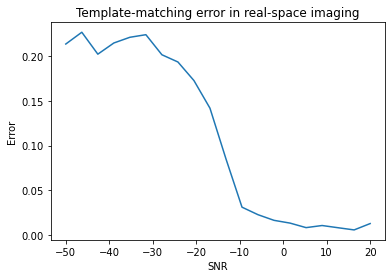

In [27]:
plt.plot(SNRs, errs)
plt.xlabel('SNR')
plt.ylabel('Error')
plt.title('Template-matching error in real-space imaging');

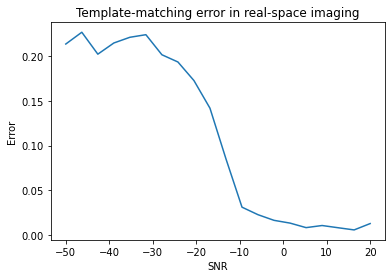

In [28]:
plt.plot(SNRs, errs)
plt.xlabel('SNR')
plt.ylabel('Error')
plt.title('Template-matching error in real-space imaging');

# Fourier space template matching

In [29]:
 def generate_fourier_proj(volume_data, num_proj=100, SNR=0, angle_scale=1):
    # First define projection geometry
    detector_shape = 300
    pixel_size = np.sqrt(3) / detector_shape  # sqrt(3) is the diagonal of the unit cube
    detector_position = (0, -2, 0)

    pg = ts.parallel_vec(
        shape=detector_shape,
        ray_dir=(0, 1, 0),
        det_pos=detector_position,
        det_v=(pixel_size, 0, 0),
        det_u=(0, 0, pixel_size),
    )

    # Then define volume geometry
    volume_size = np.array([1, 1, 1])
    anglesrot = np.random.uniform(0, 2*angle_scale*np.pi, (num_proj, 1))
    anglesazi = np.random.uniform(0, 2*angle_scale*np.pi, (num_proj, 1))
    anglessph = np.random.uniform(0, angle_scale*np.pi, (num_proj, 1))
    axis = np.concatenate(
        (np.cos(anglessph), 
        np.sin(anglessph) * np.sin(anglesazi), 
        np.sin(anglessph) * np.cos(anglesazi)), 
        axis=1
    )
    rot_axis_pos = (0, 0, 0)

    vg0 = ts.volume(
        shape=data.shape,
        pos=(0, 0, 0),
        size=volume_size,
    )
    R = ts.rotate(pos=rot_axis_pos, axis=axis, angles=anglesrot)
    vg = R * vg0.to_vec()

    A = ts.operator(vg, pg)

    ## Project data
    proj = A(volume_data)
    fourier_meas0 = torch.abs(torch.fft.ifftshift(torch.fft.fft2(proj, dim=(0, 2))))**2

    signal_lvl = torch.std(fourier_meas0)
    noise_lvl = signal_lvl * 10**(-SNR/10)
    noise = torch.randn(proj.shape, device=device) * noise_lvl
    meas = fourier_meas0 + noise

    return meas, anglesrot, anglesazi, anglessph

In [30]:
angle_scale = 0.05
fourier_meas, proj_anglesrot, proj_anglesazi, proj_anglessph = generate_fourier_proj(data, num_proj=100, angle_scale=angle_scale, SNR=50)

/home/jdong/.conda/envs/tomosipo2/lib/python3.8/site-packages/tomosipo/links/torch.py:63: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  warnings.warn(


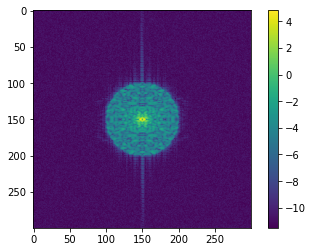

In [31]:
plt.imshow(torch.log(torch.abs(fourier_meas[:, 50, :].cpu())+1e-5))
plt.colorbar()

In [32]:
def generate_template_fourier(volume_data, Nsampl=20, angle_scale=1):
    volume_size = np.array([1, 1, 1])
    anglesrotlist = np.linspace(0, 2*angle_scale*np.pi, Nsampl)
    anglesazilist = np.linspace(0, 2*angle_scale*np.pi, Nsampl)
    anglessphlist = np.linspace(0, angle_scale*np.pi, Nsampl)
    templanglesrot, templanglesazi, templanglessph = np.meshgrid(anglesrotlist, anglesazilist, anglessphlist)
    templanglesrot = np.reshape(templanglesrot, (Nsampl**3, 1))
    templanglesazi = np.reshape(templanglesazi, (Nsampl**3, 1))
    templanglessph = np.reshape(templanglessph, (Nsampl**3, 1))
    templaxis = np.concatenate(
        (np.cos(templanglessph), 
        np.sin(templanglessph) * np.sin(templanglesazi), 
        np.sin(templanglessph) * np.cos(templanglesazi)), 
        axis=1
    )
    rot_axis_pos = (0, 0, 0)

    vg0 = ts.volume(
        shape=data.shape,
        pos=(0, 0, 0),
        size=volume_size,
    )
    R = ts.rotate(pos=rot_axis_pos, axis=templaxis, angles=templanglesrot)
    vg = R * vg0.to_vec()

    A = ts.operator(vg, pg)

    template_proj = A(volume_data)
    template_fourier = torch.abs(torch.fft.ifftshift(torch.fft.fft2(template_proj, dim=(0, 2))))**2
    return template_fourier, templanglesrot, templanglesazi, templanglessph

In [33]:
template_fourier, templanglesrot, templanglesazi, templanglessph = generate_template_proj(data, Nsampl=20, angle_scale=angle_scale)

In [34]:
def template_matching_fourier(proj_meas, template_proj):
    num_proj = proj_meas.shape[1]
    max_idx = torch.zeros(num_proj)

    template_proj = torch.log(template_proj + 1e-5)
    template_proj2 = template_proj - torch.mean(template_proj)
    for idx in range(num_proj):
        current_proj = torch.log(proj_meas[:, idx, :]+1e-5)
        current_proj2 = current_proj - torch.mean(current_proj)
        current_proj2 = torch.reshape(current_proj2, (detector_shape, 1, detector_shape))
        correlations = torch.sum(template_proj2 * current_proj2, dim=(0, 2))
        max_idx[idx] = torch.argmax(correlations)

    return max_idx

In [35]:
Fmax_idx = template_matching(fourier_meas, template_fourier)

In [36]:
err = compute_matching_error(proj_anglesrot, proj_anglessph, proj_anglesazi, templanglesrot, templanglessph, templanglesazi, Fmax_idx)
print(err)

[0.08184229]


In [37]:
idx = 60
print(proj_anglesazi[idx])
print(int(max_idx[idx]))
print(templanglesazi[int(max_idx[idx])])

[0.1658987]
0
[0.]


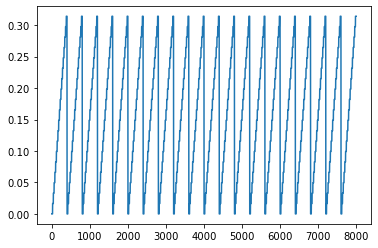

In [38]:
plt.plot(templanglesrot)